In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import ast
import random

In [4]:
advan_path = 'data/Atlanta_data/rawdata_for_meeting_March_26.csv'
acs_path = 'data/Atlanta_data/ACS_atlanta/ACSDT5Y2018.B01001-Data.csv'

In [5]:
advan_data = pd.read_csv(advan_path)
acs_data = pd.read_csv(acs_path)
# Remove the first row as it contains explanations for each column
acs_data = acs_data.iloc[1:]


In [6]:
advan_data.columns

Index(['placekey', 'location_name', 'top_category', 'naics_code', 'poi_cbg',
       'visitor_home_cbgs', 'visitor_home_aggregation', 'start_date'],
      dtype='object')

In [7]:
# Define age groups
# age_groups = {
#     'under_5_years': ['B01001_003E', 'B01001_027E'],
#     '5_to_9_years': ['B01001_004E', 'B01001_028E'],
#     '10_to_14_years': ['B01001_005E', 'B01001_029E'],
#     '15_to_17_years': ['B01001_006E', 'B01001_030E'],
#     '18_to_19_years': ['B01001_007E', 'B01001_031E'],
#     '20_years': ['B01001_008E', 'B01001_032E'],
#     '21_years': ['B01001_009E', 'B01001_033E'],
#     '22_to_24_years': ['B01001_010E', 'B01001_034E'],
#     '25_to_29_years': ['B01001_011E', 'B01001_035E'],
#     '30_to_34_years': ['B01001_012E', 'B01001_036E'],
#     '35_to_39_years': ['B01001_013E', 'B01001_037E'],
#     '40_to_44_years': ['B01001_014E', 'B01001_038E'],
#     '45_to_49_years': ['B01001_015E', 'B01001_039E'],
#     '50_to_54_years': ['B01001_016E', 'B01001_040E'],
#     '55_to_59_years': ['B01001_017E', 'B01001_041E'],
#     '60_to_61_years': ['B01001_018E', 'B01001_042E'],
#     '62_to_64_years': ['B01001_019E', 'B01001_043E'],
#     '65_to_66_years': ['B01001_020E', 'B01001_044E'],
#     '67_to_69_years': ['B01001_021E', 'B01001_045E'],
#     '70_to_74_years': ['B01001_022E', 'B01001_046E'],
#     '75_to_79_years': ['B01001_023E', 'B01001_047E'],
#     '80_to_84_years': ['B01001_024E', 'B01001_048E'],
#     '85_years_and_over': ['B01001_025E', 'B01001_049E']
# }

age_groups = {
    '00 - 09 years': ['B01001_003E', 'B01001_027E', 'B01001_004E', 'B01001_028E'], 
    '10 - 19 years': ['B01001_005E', 'B01001_029E', 'B01001_006E', 'B01001_030E', 'B01001_007E', 'B01001_031E'], 
    '20 - 29 years': ['B01001_008E', 'B01001_032E', 'B01001_009E', 'B01001_033E', 'B01001_010E', 'B01001_034E', 'B01001_011E', 'B01001_035E'], 
    '30 - 39 years': ['B01001_012E', 'B01001_036E', 'B01001_013E', 'B01001_037E'], 
    '40 - 49 years': ['B01001_014E', 'B01001_038E', 'B01001_015E', 'B01001_039E'], 
    '50 - 59 years': ['B01001_016E', 'B01001_040E', 'B01001_017E', 'B01001_041E'], 
    '60 + years': ['B01001_018E', 'B01001_042E', 'B01001_019E', 'B01001_043E', 'B01001_020E', 'B01001_044E', 'B01001_021E', 'B01001_045E', 
                   'B01001_022E', 'B01001_046E', 'B01001_023E', 'B01001_047E', 'B01001_024E', 'B01001_048E', 'B01001_025E', 'B01001_049E']
}

In [8]:
# Preprocess ACS data to get age group distribution per CBG
acs_data = acs_data.rename(columns={'GEO_ID': 'cbg'})
acs_data['cbg'] = acs_data['cbg'].str[-12:]


In [9]:
print(acs_data)

               cbg                                               NAME  \
1     130630402021  Block Group 1, Census Tract 402.02, Clayton Co...   
2     130630402022  Block Group 2, Census Tract 402.02, Clayton Co...   
3     130630402031  Block Group 1, Census Tract 402.03, Clayton Co...   
4     130630402032  Block Group 2, Census Tract 402.03, Clayton Co...   
5     130630402041  Block Group 1, Census Tract 402.04, Clayton Co...   
...            ...                                                ...   
1719  131350507292  Block Group 2, Census Tract 507.29, Gwinnett C...   
1720  131350507301  Block Group 1, Census Tract 507.30, Gwinnett C...   
1721  131350507302  Block Group 2, Census Tract 507.30, Gwinnett C...   
1722  131350507311  Block Group 1, Census Tract 507.31, Gwinnett C...   
1723  131350507312  Block Group 2, Census Tract 507.31, Gwinnett C...   

     B01001_001E B01001_001M B01001_002E B01001_002M B01001_003E B01001_003M  \
1           1492         236         614   

In [10]:
age_group_populations = {}
for group, columns in age_groups.items():
    acs_data[group] = acs_data[columns].apply(pd.to_numeric, errors='coerce').sum(axis=1)
    age_group_populations[group] = acs_data.groupby('cbg')[group].sum()

acs_age_distribution = pd.DataFrame(age_group_populations)
acs_age_distribution.reset_index(inplace=True)

In [11]:
# Normalize to get proportion of each age group per CBG
age_group_columns = list(age_groups.keys())
acs_age_distribution[age_group_columns] = acs_age_distribution[age_group_columns].div(acs_age_distribution[age_group_columns].sum(axis=1), axis=0).fillna(0)

In [12]:
print(acs_age_distribution)

               cbg  00 - 09 years  10 - 19 years  20 - 29 years  \
0     130630402021       0.185657       0.178284       0.295576   
1     130630402022       0.251228       0.111579       0.167018   
2     130630402031       0.061475       0.067623       0.327869   
3     130630402032       0.163572       0.088988       0.206786   
4     130630402041       0.232649       0.137701       0.243198   
...            ...            ...            ...            ...   
1718  131350507292       0.088814       0.226780       0.129153   
1719  131350507301       0.143010       0.181039       0.075790   
1720  131350507302       0.174518       0.139614       0.129682   
1721  131350507311       0.147322       0.185039       0.163784   
1722  131350507312       0.133321       0.142908       0.114326   

      30 - 39 years  40 - 49 years  50 - 59 years  60 + years  
0          0.099866       0.108579       0.056971    0.075067  
1          0.104561       0.157193       0.115088    0.093333  
2  

In [13]:
# Preprocess Advan data to get visitation distribution by CBG for each POI
advan_data = advan_data.rename(columns={'placekey': 'poi_id', 'visitor_home_cbgs': 'visitor_cbg', 'visits_by_day': 'visits'})

# Parse the 'visitor_cbg' column to convert it from string to dictionary
advan_data['visitor_cbg'] = advan_data['visitor_cbg'].apply(lambda x: ast.literal_eval(str(x)) if pd.notna(x) else {})


In [14]:
# Construct contact matrices for each POI and week
contact_matrices = {}
for _, row in advan_data.iterrows():
    poi_id = row['poi_id']
    week = row['start_date']  # Assuming there's a column that represents the week
    visitor_cbgs = row['visitor_cbg']
    
    # Estimate the demographic composition of visitors
    visitor_demographics = pd.Series(0, index=age_groups.keys(), dtype=float)
    for cbg, count in visitor_cbgs.items():
        if cbg in acs_age_distribution['cbg'].values:
            cbg_age_distribution = acs_age_distribution.loc[acs_age_distribution['cbg'] == cbg, age_group_columns].iloc[0]
            if cbg_age_distribution.sum() > 0:  # Only sample if the population is greater than 0
                sampled_visitors = pd.Series([0] * len(age_group_columns), index=age_group_columns)
                for _ in range(count):
                    sampled_age_group = random.choices(age_group_columns, weights=cbg_age_distribution)[0]
                    sampled_visitors[sampled_age_group] += 1
                visitor_demographics += sampled_visitors
    
    # Normalize the visitor demographics
    total_visits = visitor_demographics.sum()
    # if total_visits > 0:
    #     visitor_demographics /= total_visits
    
    # Create contact matrix for the POI for the given week
    contact_matrix = pd.DataFrame(0, index=age_groups.keys(), columns=age_groups.keys())
    for age_group_1 in age_groups.keys():
        for age_group_2 in age_groups.keys():
            # Assume interaction rate is proportional to the product of the proportions
            contact_matrix.loc[age_group_1, age_group_2] = (
                visitor_demographics.get(age_group_1, 0) * visitor_demographics.get(age_group_2, 0)
            )
    
    # Store the contact matrix
    contact_matrices[(poi_id, week)] = contact_matrix

In [15]:
# Example: Print contact matrix for a specific POI and week
poi_example, week_example = list(contact_matrices.keys())[0]
contact_matrix_example = contact_matrices[(poi_example, week_example)]
print(f"Contact Matrix for POI {poi_example} during week {week_example}:")
print(contact_matrix_example)

Contact Matrix for POI zzw-223@8g7-26q-8n5 during week 1/22/2018:
               00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
00 - 09 years            196            196            154            182   
10 - 19 years            196            196            154            182   
20 - 29 years            154            154            121            143   
30 - 39 years            182            182            143            169   
40 - 49 years            224            224            176            208   
50 - 59 years            280            280            220            260   
60 + years               196            196            154            182   

               40 - 49 years  50 - 59 years  60 + years  
00 - 09 years            224            280         196  
10 - 19 years            224            280         196  
20 - 29 years            176            220         154  
30 - 39 years            208            260         182  
40 - 49 years            25

In [16]:
import pickle

# Save contact_matrices to a file
with open('atlanta_selected_contact_matrices.pkl', 'wb') as f:
    pickle.dump(contact_matrices, f)

In [4]:
import pickle
with open('atlanta_contact_matrices.pkl', 'rb') as file:
    contact_matrices = pickle.load(file)

In [17]:
contact_matrices

{('zzw-223@8g7-26q-8n5',
  '1/22/2018'):                00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
 00 - 09 years            196            196            154            182   
 10 - 19 years            196            196            154            182   
 20 - 29 years            154            154            121            143   
 30 - 39 years            182            182            143            169   
 40 - 49 years            224            224            176            208   
 50 - 59 years            280            280            220            260   
 60 + years               196            196            154            182   
 
                40 - 49 years  50 - 59 years  60 + years  
 00 - 09 years            224            280         196  
 10 - 19 years            224            280         196  
 20 - 29 years            176            220         154  
 30 - 39 years            208            260         182  
 40 - 49 years            256          

In [7]:
# Example: Print contact matrix for a specific POI and week
poi_example, week_example = list(contact_matrices.keys())[0]
contact_matrix_example = contact_matrices[(poi_example, week_example)]
print(f"Contact Matrix for POI {poi_example} during week {week_example}:")
print(contact_matrix_example)

Contact Matrix for POI 222-222@8g7-4bt-h5z during week 2018-01-01:
               00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
00 - 09 years              1              4              0              2   
10 - 19 years              4             16              0              8   
20 - 29 years              0              0              0              0   
30 - 39 years              2              8              0              4   
40 - 49 years              2              8              0              4   
50 - 59 years              4             16              0              8   
60 + years                 5             20              0             10   

               40 - 49 years  50 - 59 years  60 + years  
00 - 09 years              2              4           5  
10 - 19 years              8             16          20  
20 - 29 years              0              0           0  
30 - 39 years              4              8          10  
40 - 49 years             

In [ ]:
# Normalize each row so each row sums to 1
contact_matrix_normalized = contact_matrix_example.div(contact_matrix_example.sum(axis=1), axis=0)
# contact_matrix_normalized = contact_matrix_example / contact_matrix_example.sum().sum()
print(contact_matrix_normalized)

               00 - 09 years  10 - 19 years  20 - 29 years  30 - 39 years  \
00 - 09 years       0.055556       0.222222            0.0       0.111111   
10 - 19 years       0.055556       0.222222            0.0       0.111111   
20 - 29 years            NaN            NaN            NaN            NaN   
30 - 39 years       0.055556       0.222222            0.0       0.111111   
40 - 49 years       0.055556       0.222222            0.0       0.111111   
50 - 59 years       0.055556       0.222222            0.0       0.111111   
60 + years          0.055556       0.222222            0.0       0.111111   

               40 - 49 years  50 - 59 years  60 + years  
00 - 09 years       0.111111       0.222222    0.277778  
10 - 19 years       0.111111       0.222222    0.277778  
20 - 29 years            NaN            NaN         NaN  
30 - 39 years       0.111111       0.222222    0.277778  
40 - 49 years       0.111111       0.222222    0.277778  
50 - 59 years       0.111111       

In [9]:
print(contact_matrix_normalized.sum().sum())

6.0


In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.imshow(contact_matrix_normalized, cmap='viridis', aspect='auto')
for i in range(contact_matrix_normalized.shape[0]):
    for j in range(contact_matrix_normalized.shape[1]):
        plt.text(j, i, f'{contact_matrix_normalized.iloc[i, j]:.2f}', ha='center', va='center', color='w')
plt.colorbar(label='Probability')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys(), rotation=90)
plt.yticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys())
plt.title(f"Normalized Contact Matrix for POI {poi_example} during week {week_example}")
plt.xlabel("Age Group")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()


NameError: name 'contact_matrix_normalized' is not defined

<Figure size 1000x800 with 0 Axes>

In [17]:
# Aggregate contact matrices of the same POI
monthly_contact_matrices = {}
for (poi_id, week), contact_matrix in contact_matrices.items():
    if poi_id not in monthly_contact_matrices:
        monthly_contact_matrices[poi_id] = contact_matrix
    else:
        monthly_contact_matrices[poi_id] += contact_matrix

In [19]:
poi_example = list(monthly_contact_matrices.keys())[0]
aggregated_contact_matrix = monthly_contact_matrices[poi_example]

# Normalize the entire aggregated contact matrix so that the sum of all elements is 1
aggregated_contact_matrix_normalized = aggregated_contact_matrix # / aggregated_contact_matrix.sum().sum()

# Plot the aggregated contact matrix with color based on probability
plt.figure(figsize=(10, 8))
plt.imshow(aggregated_contact_matrix_normalized, cmap='viridis', aspect='auto')
for i in range(aggregated_contact_matrix_normalized.shape[0]):
    for j in range(aggregated_contact_matrix_normalized.shape[1]):
        plt.text(j, i, f'{aggregated_contact_matrix_normalized.iloc[i, j]:.2f}', ha='center', va='center', color='w')
plt.colorbar(label='Probability')
plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys(), rotation=90)
plt.yticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys())
plt.title(f"Normalized Aggregated Contact Matrix for POI {poi_example}")
plt.xlabel("Age Group")
plt.ylabel("Age Group")
plt.tight_layout()
plt.show()

NameError: name 'monthly_contact_matrices' is not defined

In [20]:
# Trend Analysis
age_groups_name = list(age_groups.keys())
age_group_pairs = [(i, j) for i in range(len(age_groups_name)) for j in range(i, len(age_groups_name))]
trends = {}
weeks = []

# Filter for POIs in the "Elementary and Secondary Schools" category
school_pois = advan_data[advan_data['top_category'] == "Elementary and Secondary Schools"]['poi_id'].unique()

# Randomly pick 5 POIs
random.seed(42)
selected_pois = random.sample(list(school_pois), 5)

for poi, week in contact_matrices.keys(): 
    if poi in selected_pois: 
        if poi not in trends: 
            trends[poi] = {pair: [] for pair in age_group_pairs}
        
        for pair in age_group_pairs:
            trends[poi][pair].append(contact_matrices[(poi, week)].iloc[pair[0], pair[1]])
    if week not in weeks: 
        weeks.append(week)
weeks

['1/22/2018',
 '3/12/2018',
 '3/5/2018',
 '3/19/2018',
 '2/19/2018',
 '2/12/2018',
 '2/26/2018',
 '1/29/2018',
 '1/15/2018',
 '1/8/2018',
 '2/5/2018']

In [21]:
selected_pois

['zzw-224@8g7-2m6-wrk',
 '222-223@8g6-yjp-p35',
 'zzw-223@8g7-26q-8n5',
 'zzw-222@8g6-yrc-35z',
 '224-222@8gb-7gh-xkf']

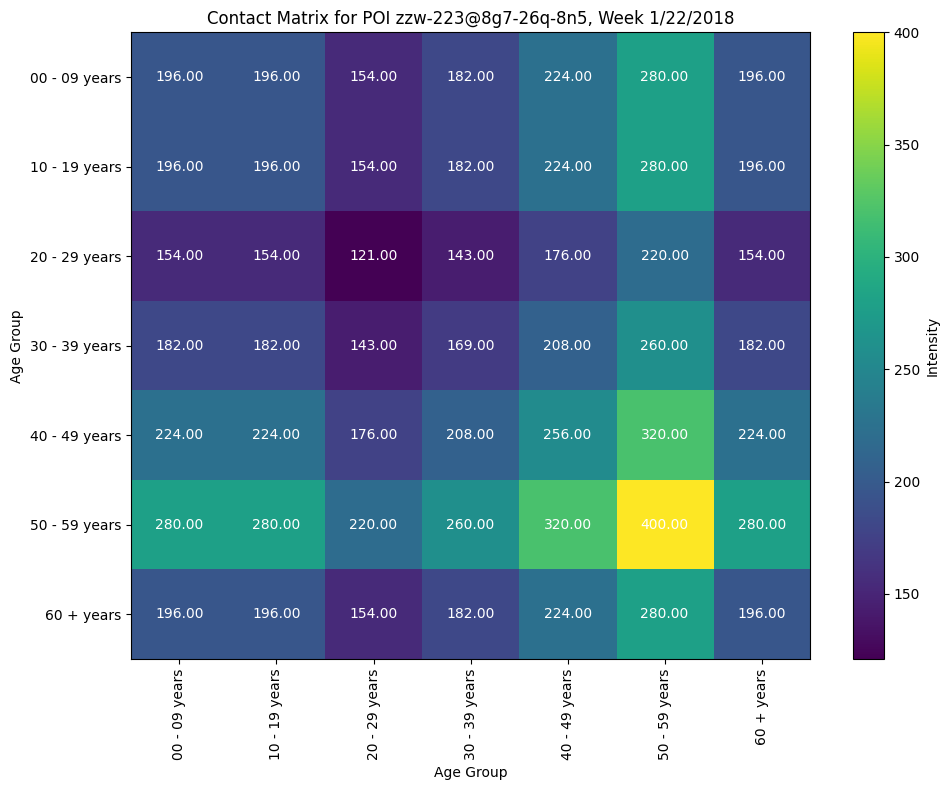

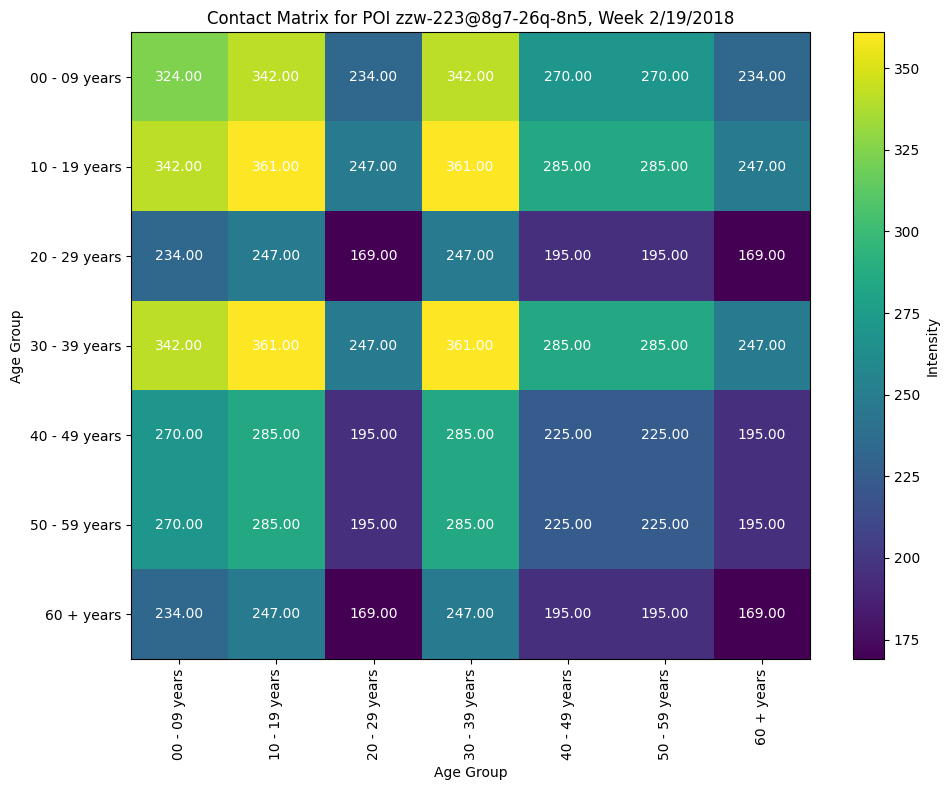

In [25]:
n = 0
selected_poi = ""
for poi in selected_pois: 
    if n < 2: 
        n+=1
        continue
    else:
        selected_poi = poi
        for week in weeks: 
            if (poi, week) in contact_matrices: 
                poi_contact_matrix = contact_matrices[(poi, week)]
            else: 
                continue
            plt.figure(figsize=(10, 8))
            plt.imshow(poi_contact_matrix, cmap='viridis', aspect='auto')
            for i in range(poi_contact_matrix.shape[0]):
                for j in range(poi_contact_matrix.shape[1]):
                    plt.text(j, i, f'{poi_contact_matrix.iloc[i, j]:.2f}', ha='center', va='center', color='w')
            plt.colorbar(label='Intensity')
            plt.xticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys(), rotation=90)
            plt.yticks(ticks=np.arange(len(age_groups)), labels=age_groups.keys())
            plt.title(f"Contact Matrix for POI {poi}, Week {week}")
            plt.xlabel("Age Group")
            plt.ylabel("Age Group")
            plt.tight_layout()
            plt.show()
    break

In [23]:
advan_data[advan_data['poi_id'] == selected_poi]


,poi_id,location_name,top_category,naics_code,poi_cbg,visitor_cbg,visitor_home_aggregation,start_date
0,zzw-223@8g7-26q-8n5,Sugar Hill Christian Academy,Elementary and Secondary Schools,611110,1.313510e+11,"{'131350501071': 11, '131350501082': 10, '1313...","{""13135050103"":15,""13135050108"":12,""1313505010...",1/22/2018
6,zzw-223@8g7-26q-8n5,Sugar Hill Christian Academy,Elementary and Secondary Schools,611110,1.313510e+11,"{'131350501031': 11, '131350501071': 11, '1313...","{""13135050103"":21,""13135050106"":12,""1313505010...",2/19/2018


C:\Users\james\AppData\Local\Temp\ipykernel_22992\4293368890.py:14: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))


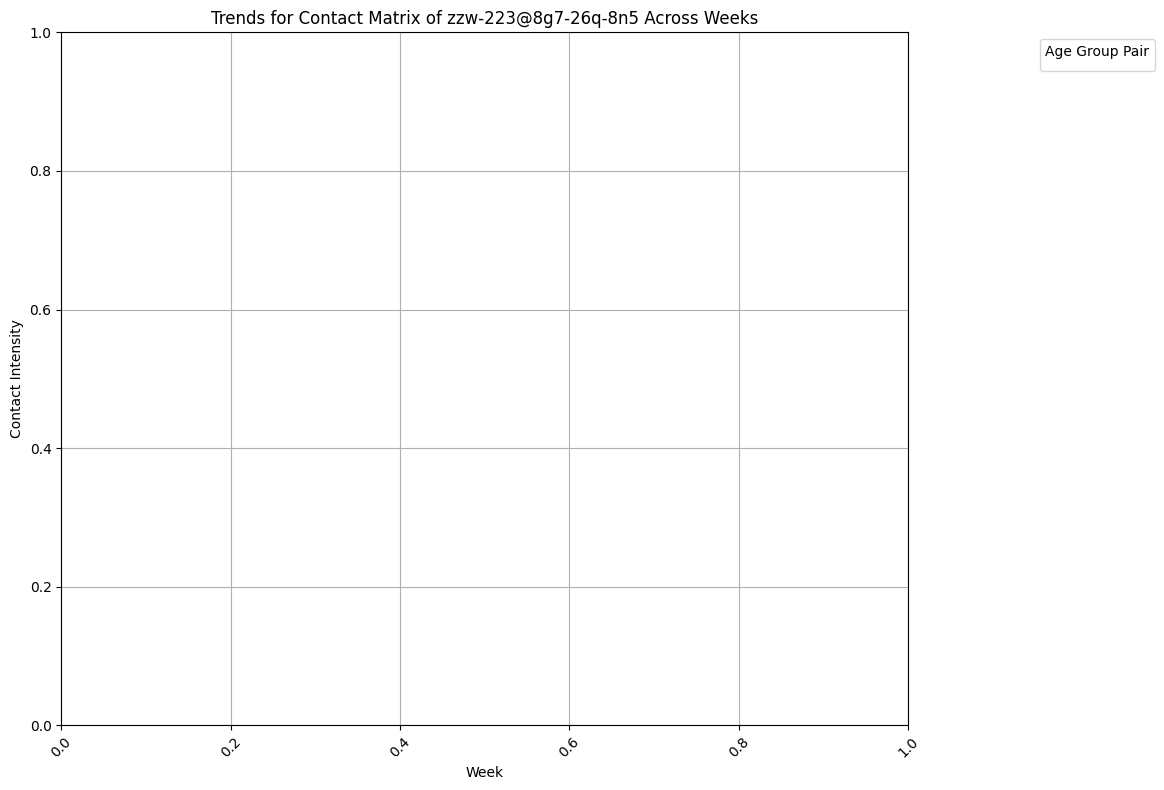

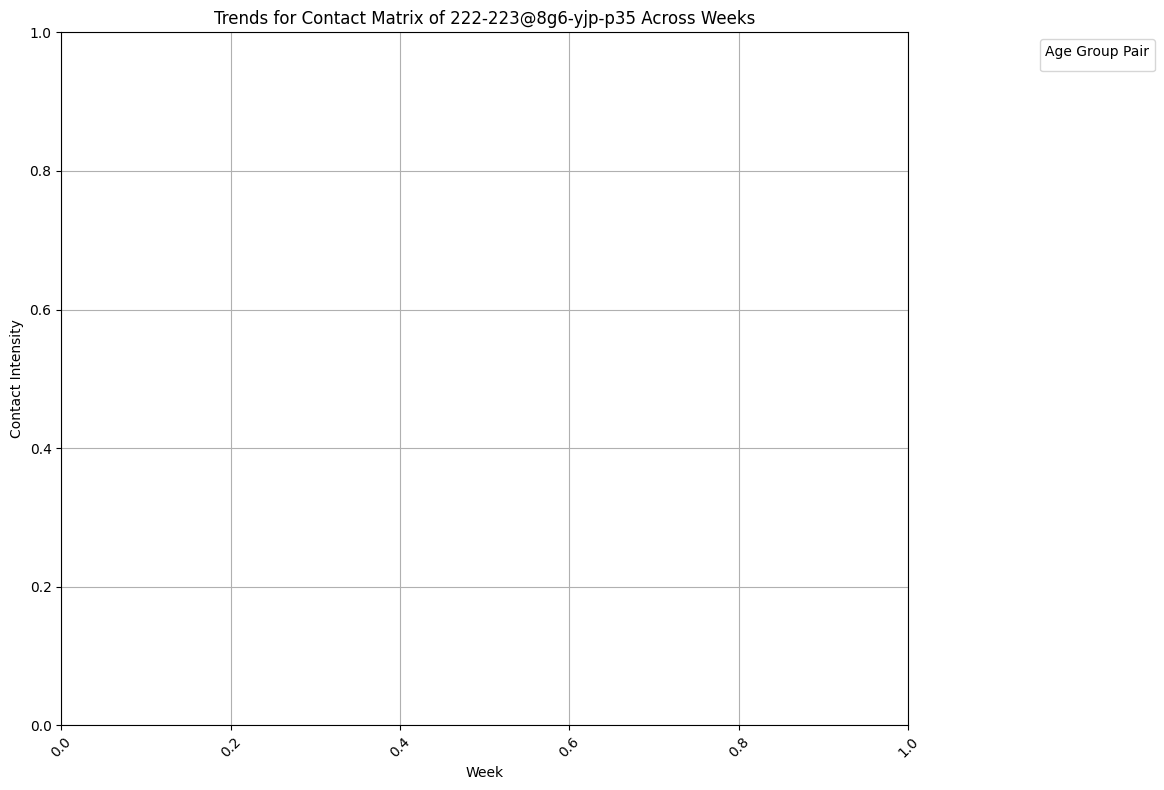

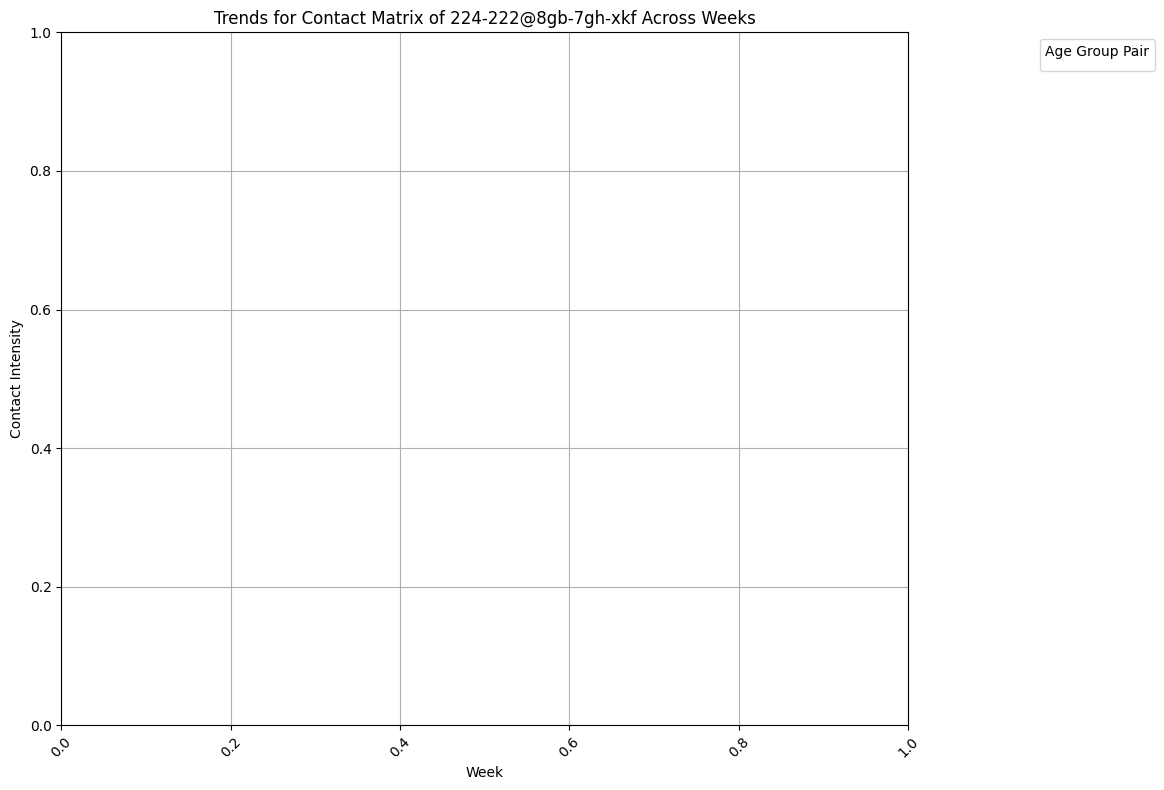

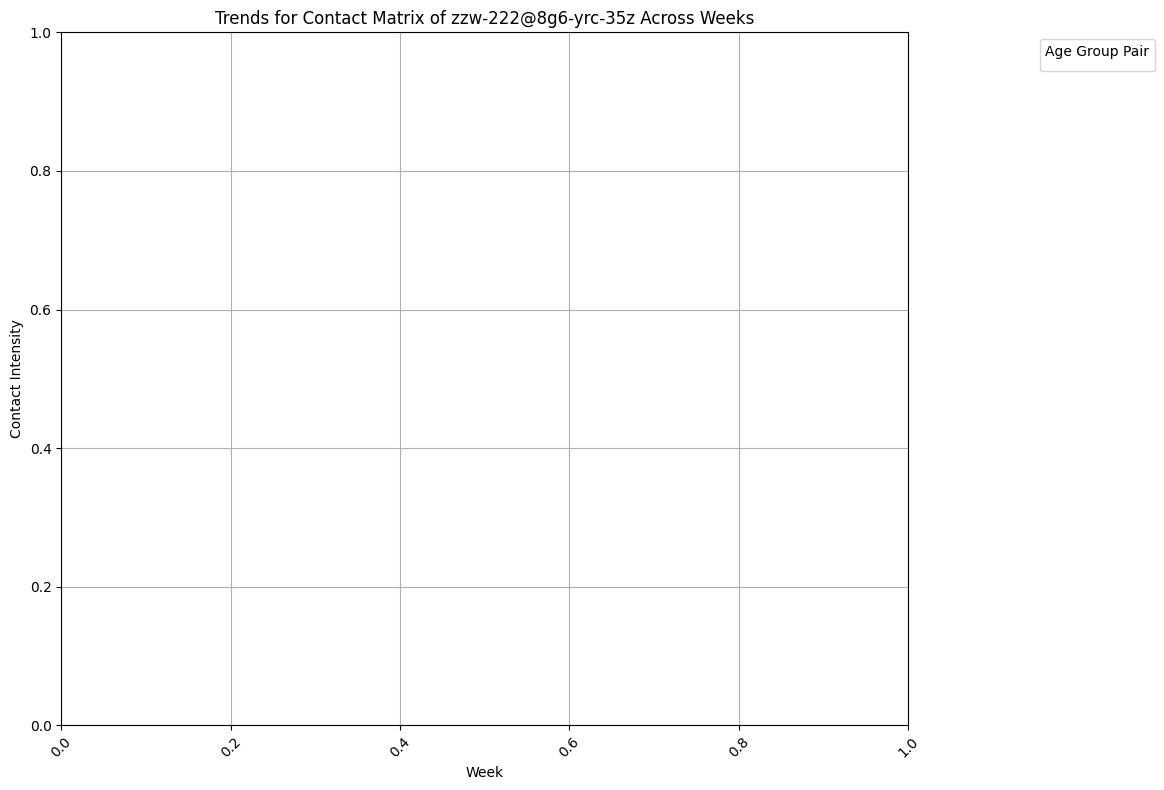

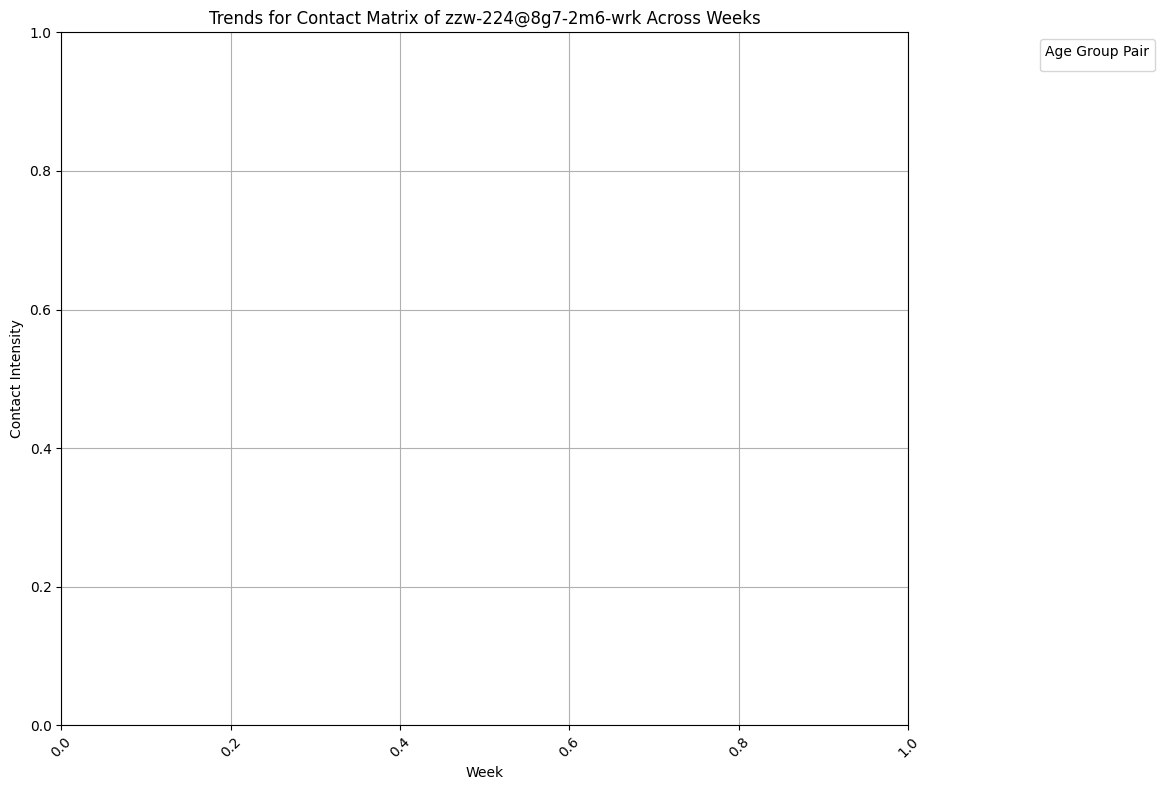

In [24]:
for poi in trends.keys(): 
    
    plt.figure(figsize=(12, 8))
    for pair in age_group_pairs:
        if len(trends[poi][pair]) != len(weeks): 
            continue
        plt.plot(weeks, trends[poi][pair], label=f"{age_groups_name[pair[0]]} ↔ {age_groups_name[pair[1]]}")

    # Add plot details
    plt.title(f"Trends for Contact Matrix of {poi} Across Weeks")
    plt.xlabel("Week")
    plt.ylabel("Contact Intensity")
    plt.xticks(rotation=45)
    plt.legend(title="Age Group Pair", loc='upper right', bbox_to_anchor=(1.3, 1))
    plt.grid(True)
    plt.tight_layout()

    # Show the plot
    plt.show()